## Лабораторная работа №2

**Цель** —разработать и обучить сверточную нейронную сеть для задачи классификации изображений на наборе данных [Cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) с использованием  PyTorch. 

### Требования к результатам выполнения работы

1. Требования к структуре и содержимому Jupyter Notebook:
    - Загрузить и проверить данные (необходимо обеспечить демонстрацию избранных изображений и меток классов для подтверждения корректности загрузки и совпадения размерностей).
    - Реализовать архитектуру нейронной сети с использованием фреймворка PyTorch.
    - Настроить гиперпараметры обучения (например, архитектуры, скорости обучения и размера пачки (batch size)).
    - Вывести ошибку классификации и точность на тренировочном наборе данных по окончании каждой эпохи.
    - Вывести ошибку классификации на тестовом наборе данных и построить график ошибки обучения после обучения.

2. Выбор архитектуры:
    - Необходимо использовать ***сверточные*** архитектуры нейронных сетей
    - Разрешается использовать как готовые архитектуры (например, VGG, ResNet и тд), так и архитектуры разработанные студентом самостоятельно. 
    - Реализация должна быть выполнена с нуля в PyTorch, без использования готовых модулей (например, import Resnet недопустимо).

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from time import time
from torch.utils.data import DataLoader
%matplotlib inline

In [7]:
BATCH_SIZE = 256
NUM_EPOCHS = 50
LEARNING_RATE = 0.1
LEARNING_RATE_MIN = 0.0001
SCHEDULING_FACTOR = 0.7
SCHEDULING_PATIENCE = 3

### Подготовка данных

Датасет `Cifar-10` (https://www.cs.toronto.edu/~kriz/cifar.html)

### Загрузка данных

Для загрузки данных был использован материал с сайта: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

print("Batch size:", BATCH_SIZE)

train_dataset = datasets.CIFAR10(root='/data/cifar-10-batches-py', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.CIFAR10(root='/data/cifar-10-batches-py', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Batch size: 256


100.0%


Extracting /data/cifar-10-batches-py\cifar-10-python.tar.gz to /data/cifar-10-batches-py
Files already downloaded and verified


### Проверка загрузки данных

Размеры тестовых и тренировочных выборок

In [9]:
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 50000
Test dataset size: 10000


Визуалиция 16 случайных изображений в тренировочной выборке

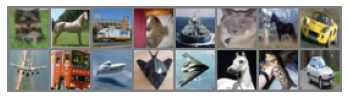

  dog horse truck   cat  ship   cat horse   car plane truck  ship plane plane horse   cat   car


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off') 
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:16]))
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

### Нейронная сеть

`ResNet-18`

In [15]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = nn.functional.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = nn.functional.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = nn.functional.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out

class ResNet18(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = nn.functional.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out
    
    def test(self, loader, loss_fn):
        correct = 0
        total = 0
        loss = 0.0
        device = next(self.parameters()).device
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss += loss_fn(outputs, labels).item()
        loss /= len(loader)
        return correct, total, loss
        

        

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet18(BasicBlock, [2,2,2,2]).to(device=device)

cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=SCHEDULING_FACTOR, patience=SCHEDULING_PATIENCE, min_lr=LEARNING_RATE_MIN)

In [18]:
best_accuracy = 0.0
training_error = []
total_start_time = time()

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    end_time = time()

    training_error.append(1 - correct / total)
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], Elapsed {end_time - start_time:.2f} seconds, '
          f'Learning rate {scheduler.get_last_lr()[-1]:.4f}, ' 
          f'Loss: {total_loss/len(train_loader):.4f}, '
          f'Accuracy: {100 * correct / total:.2f}%')

    model.eval()
    test_correct, test_total, test_loss = model.test(test_loader, cross_entropy_loss)
    scheduler.step(test_loss)
    model.train()
    test_accuracy = 100 * test_correct / test_total
    print(f'Test Accuracy: {test_accuracy:.2f}%')

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved new best model with accuracy: {best_accuracy:.2f}%")

total_end_time = time()
print(f'Finished Training. Total training time: {total_end_time - total_start_time:.2f} seconds')

Epoch [1/50], Elapsed 70.54 seconds, Learning rate 0.1000, Loss: 1.5605, Accuracy: 43.01%
Test Accuracy: 51.41%
Saved new best model with accuracy: 51.41%
Epoch [2/50], Elapsed 63.45 seconds, Learning rate 0.1000, Loss: 1.0697, Accuracy: 61.86%
Test Accuracy: 55.03%
Saved new best model with accuracy: 55.03%
Epoch [3/50], Elapsed 63.40 seconds, Learning rate 0.1000, Loss: 0.8035, Accuracy: 71.51%
Test Accuracy: 70.74%
Saved new best model with accuracy: 70.74%
Epoch [4/50], Elapsed 63.37 seconds, Learning rate 0.1000, Loss: 0.6242, Accuracy: 78.11%
Test Accuracy: 76.16%
Saved new best model with accuracy: 76.16%
Epoch [5/50], Elapsed 65.56 seconds, Learning rate 0.1000, Loss: 0.4996, Accuracy: 82.67%
Test Accuracy: 76.08%
Epoch [6/50], Elapsed 65.64 seconds, Learning rate 0.1000, Loss: 0.4017, Accuracy: 85.85%
Test Accuracy: 78.61%
Saved new best model with accuracy: 78.61%
Epoch [7/50], Elapsed 64.47 seconds, Learning rate 0.1000, Loss: 0.3216, Accuracy: 88.78%
Test Accuracy: 79.79%
S

In [19]:
model.load_state_dict(torch.load('best_model.pth', weights_only=True))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 84.64%


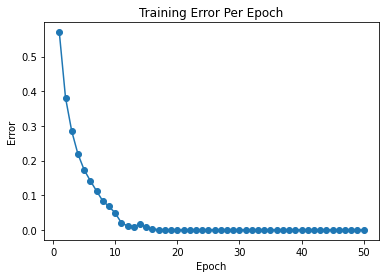

In [20]:
plt.plot(range(1, NUM_EPOCHS + 1), training_error, marker='o')
plt.title('Training Error Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.show()